In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
file_path = './shakespeare.txt'

with open(file_path, 'r') as f:
    file = f.read()

# Create a set of unique characters
all_chars = set(file)
all_chars.update(set(string.printable))
all_chars = sorted(all_chars)
n_chars = len(all_chars)
file_len = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: ['\t', '\n', '\x0b', '\x0c', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    n_chars = len(all_chars)
    tensor  = torch.zeros(len(seq), 1, n_chars)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        try:
            index = all_chars.index(char)
            tensor[t][0][index] = 1
        except ValueError:
            print(f"Character '{char}' not found in all_chars.")
            raise
    return tensor


# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input1  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input1, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.rnn = nn.RNNCell(input_size=self.input_size, hidden_size=self.hidden_size, bias=False)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.output_size, bias=False)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 100, bias=False)
  (linear): Linear(in_features=100, out_features=100, bias=False)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 100000  # Number of training iterations.
print_iters = 5000    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(float(loss_sum) / print_iters)
        loss_sum = 0

iter:4999/100000 loss:2.1112751960754395
generated sequence: WYock not nis sle:
enged, are world yeadfure
And brur.

HERCURANDI:
Why see, be stand and not
You hav

iter:9999/100000 loss:1.877416968345642
generated sequence: What aave rememsed?
And I have of this miglimenoss for hieks, brewy.

BAPNICHARD III:
Theister:
And a

iter:14999/100000 loss:1.827233910560608
generated sequence: Whar of arand tell that betoll. Grey her brod wede, siding nevenge, bown bear be? and not baseib'd tr

iter:19999/100000 loss:1.7988007068634033
generated sequence: WAThENIUS:
Noy say morieproing you That are haypes.

BUCKIN:
Then -her I hmather borim; I, lawior of 

iter:24999/100000 loss:1.7848849296569824
generated sequence: Where couns but with those, and side onour.

KING RATH:
O
'Touch nor Gan, me hidreser'd us thoughter;

iter:29999/100000 loss:1.786958932876587
generated sequence: WICKITH
YORK:
No, me love of Great. If not this?
Or, fray.
Thy most gave ordengs the prince himsel.
O

iter:34999/1000

#### Training Loss Curve

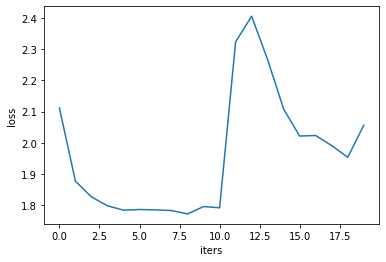

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

Whalt af wherd'd oulir heak I yir bee the kid by'd wokiof ind ingn, thr hit,
A
, thim to ty tik apely his dut in off or'd the froundy lin cupe,n
The anll ee cown ancess housilprly; and themen keincin on sioms siseongh
A frert yytb I
re ixs noin, any; oft thoust in to melp frise it!
Lod thin by anournan Bord dichaes-
Fir kin,
Ince you felss hist in herl
I thin Naurswe drre curl;
Thin we purl I?

Fnise see nall thea ou yaysid, lark shast:
A:
Tham the des
, de to the way.
Iuther then rit, and knsnout I dvrter suatINENNDWEN:
As wein say be f ee rring yoW the he daich' wnin you? withutche likem mare
